#Questions
- if one point is have equal distances to multiple segs, how to assign seg to it

In [1]:
%pylab inline
import geopandas as gp
from shapely.geometry import LineString, Point
import rtree
import os
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Functions

build_load_idx(seg_idx_path,segs,update=False): indexing segments

pt2seg(pt,seg_idx): find the segment intersected/nearest to a given point

In [2]:
def build_load_idx(seg_idx_path, segs_with_ids, update=False):
    """
    params:
        seg_idx_path: the path of segment index if the index doesn't exist, the index will be built.
        segs_with_ids: dict: key=objid, value=shapely.geometry.LineString, segments that will be indexed
        update: True: rebuild the index no matter whether the index exists
    Output:
        rtree index of given segments.
    """
    idx_exist = os.path.isfile(seg_idx_path+'.dat') & os.path.isfile(seg_idx_path+'.idx') 
    if update and idx_exist:
        print 'remove existing files'
        os.remove(seg_idx_path+'.dat')
        os.remove(seg_idx_path+'.idx')
        idx_exist = False
    seg_idx = rtree.index.Rtree(seg_idx_path)
    if not idx_exist:
        print 'building idx'
#         seg_idx?
        for objid,seg in segs_with_ids.items():
            seg_idx.insert(objid, seg.bounds)
        print 'built idx'

    return seg_idx

def pt2seg(pt, segs_with_ids, seg_idx):
    """
    params: 
        pt: shapely.geometry.Point
        segs_with_ids:
        seg_idx: rtree index of segments
    Process:
        1. load segment index and find segments(var:idx_match) whose bounds intersect with point's bounds
           if there isn't any matched segment, the point will be buffered until len of idx_match !=0
        2. find the segments that actually intersect with given point
           if there isn't any intersected segment, nearest segment will be returned
    Output:
       hint: whether the returned segid is "nearest" or "intersected"
       segid: assigned segment id
       cnt: len of candidates 
       candidates: the index of segments that are "equally near"/"intersected" to the point
       distance: the distance between point and segment
    """
    
    idx_match = list(seg_idx.intersection(pt.bounds))

    # in case no idx is matched
    bfr_value = 0.000001
    while len(idx_match)==0:
        idx_match = list(seg_idx.intersection(pt.buffer(bfr_value).bounds))
        bfr_value*=2
    
    fil = [pt.intersects(segs_with_ids[idx]) for idx in idx_match]
    seg_match = [idx for (idx,b) in zip(idx_match, fil) if b]
    
    if len(seg_match)==0:
        dis = np.array([pt.distance(segs_with_ids[idx]) for idx in idx_match])
        minimum = dis.min()
        segid = idx_match[dis.argmin()]
        return 'nearest', segid, int(numpy.where(dis==minimum)[0].shape[0]), np.array(idx_match)[np.where(dis==minimum)[0]],minimum
    else:
        segid=seg_match[0]
        return 'intersected', segid, len(seg_match), np.array(seg_match),0

# test data

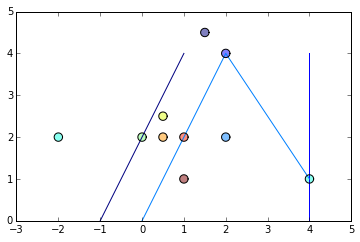

In [3]:
pts = [
    (-2,2), # outside any indexed bounds, closest to only 1 seg
    (0,2), # on seg 0
    (0.5,2.5), # idx_match multiple segs
    (0.5,2), # has equal distances between multiple segs
    (1,2), # on seg 1
    (1,1), # idx_match multiple segs
    (1.5,4.5), # outside any indexed bounds, has equal distances between multiple segs
    (2,4), # on seg 1
    (2,2), # idx_match only seg 1 
    (4,1), # in the intersection of multiple segs
]
segs = [
    [(-1,0),(1,4)],
    [(4,0),(4,4)],
    [(0,0),(2,4),(4,1)],
]
# objids = [i for i in range(len(segs))]
segs_with_objids = dict(zip([i for i in range(len(segs))],[LineString(seg) for seg in segs]))
pts = [Point(pt) for pt in pts]
pts_bfr = [pt.buffer(0.1) for pt in pts]
gp.GeoDataFrame(segs_with_objids.values()+pts_bfr,columns=['geometry']).plot()

read or build an index for segments

In [4]:
seg_idx_path = 'test_seg_idx'
seg_idx = build_load_idx(seg_idx_path,segs_with_objids)

find the intersected/nearest segment for a given point

In [5]:
seg_idx_path = 'test_seg_idx'
for i in [2,6,9]:
    pt = pts[i]
    print '\n', '**************%s**************' %pt
    hint, segid, cnt, candidates, distance = pt2seg(pt, segs_with_objids, seg_idx)
    print 'the %s seg\'s id is #%d, cnt=%d, candidates=%s, distance=%f' % (hint, segid, cnt,candidates,distance)


**************POINT (0.5 2.5)**************
the nearest seg's id is #0, cnt=1, candidates=[0], distance=0.223607

**************POINT (1.5 4.5)**************
the nearest seg's id is #0, cnt=2, candidates=[0 2], distance=0.707107

**************POINT (4 1)**************
the intersected seg's id is #1, cnt=2, candidates=[1 2], distance=0.000000


close the index

In [6]:
seg_idx.close()

# Open DC data

- Street segments in DC
- moving violation

In [7]:
dc_segs = gp.read_file('Street_Segments.geojson')
mv_ptns = gp.read_file('Moving_Violations_in_January_2016.geojson')

In [8]:
segs_with_ids = dict(zip(dc_segs.STREETSEGID,dc_segs.geometry))
dc_seg_idx_path = 'dc_seg_idx'
dc_seg_idx = build_load_idx(dc_seg_idx_path, segs)

In [9]:
get_seg = mv_ptns.geometry.apply(lambda x: gp.GeoSeries(pt2seg(x, segs_with_ids, dc_seg_idx)))
get_seg.columns=[['hint','seg','len_can','candidates','distance']]
mv_ptns_get_seg = mv_ptns.join(get_seg)

{1: 79111}


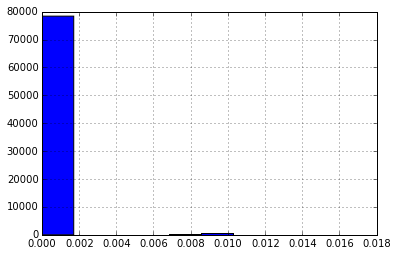

In [10]:
# mv_ptns_get_seg[['seg','STREETSEGID']][mv_ptns_get_seg.seg!=mv_ptns_get_seg.STREETSEGID]
print mv_ptns_get_seg.len_can.value_counts().to_dict()
mv_ptns_get_seg['distance'].hist()

In [11]:
dc_seg_idx.close()